In [1]:
import re, os, json, wikipedia
import urllib.request
import numpy    as np
import pandas   as pd
import networkx as nx
import string
import math
import tqdm
import lxml
import nltk
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.probability import FreqDist

# Sentiment

First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.

Now grab the good/bad character names ([from this file](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/b1668fe5fbea0765ed6f9cf896bfaf208a13765b/files/wiki_meta_data.csv), see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.

Finally use the label permutation test (see Week 5) to investigate the two hypotheses below
* H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
* H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

Write a short paragraph reflecting on your findings.

In [2]:
with open('Data_Set_S1.txt','r') as f:
    sen = f.readlines()
    f.close()

sen    = [line.split("\t") for line in sen]
df_sen = pd.DataFrame(data=sen[4:], columns=sen[3:4])

In [3]:
# a dict for later calculating of sentiment score
# in form of (word, score) 
senDict = {df_sen.iloc[i,0]:float(df_sen.iloc[i,2]) for i in range(len(df_sen))}

In [7]:
# Load .csv
# only the names and content are relevant
# please download the followed file into the same dir as this notebook
# https://dtudk-my.sharepoint.com/:x:/g/personal/s216410_dtu_dk/EdFxEEv95o1JoBtjlCrd55IBzhBeXX8HJa9AX_GSAkYUfg?e=4fVfOx

df = pd.read_csv('df_base.csv', engine='python')
df.drop(columns=['Unnamed: 0'], inplace=True)


In [9]:
df_all = df.copy()
df_all.name = 'all comic Characters'
df_all.drop(columns=['Title','WikiLink','Universe','PageID', 'URL', 'CharacterID'],
                inplace=True)

In [10]:
def tokenize_clean(readin):
    try:
        tokenizer = nltk.RegexpTokenizer(r"\w+")
        punRemove = tokenizer.tokenize(readin)
        text      = [w for w in punRemove if not w 
                        in stopwords.words('english')]
    except:
        text = []
    return text

# shorten fucntion for lemamation
def lemmatization(word):
    lemma = nltk.wordnet.WordNetLemmatizer()
    return lemma.lemmatize(word)

In [11]:
# adding clear tokens
# this would take long
df_all['Tokens'] = df_all.Content.apply(tokenize_clean) 
df_all['Tokens'] = df_all.Tokens.apply(lambda x: [lemmatization(i)
                                            for i in x])

In [12]:
# have frequences of tokens and sort out the tokens with score
df_all['tf'] = df_all.Tokens.apply(FreqDist) 
df_all['availableTokens'] = df_all.tf.apply(lambda x: 
                                list(set(x.keys()) &
                                    set(senDict.keys()))) 

In [13]:
# clear up tf with comparison of the available ones
df_all['tf'] = [{w: df_all.loc[i]['tf'][w] 
                    for w in df_all.loc[i]['availableTokens']} 
                        for i in range(df_all.shape[0])]

In [14]:
# mark the length of tf list for later calculation
# have sentiment set with both values and tokens
# recalculate the sentiment after total score is in
df_all['numOftf']   = df_all.tf.apply(len)
df_all['Sentiment'] = df_all.tf.apply(lambda x:
                                        {w: senDict[w]*s for w,s in x.items()})
df_all['totalSentiment'] = df_all.Sentiment.apply(lambda x: sum(x.values()))
df_all['Sentiment']= df_all['totalSentiment']/df_all['numOftf']

In [15]:
def stats(df):
    df.mean      = np.mean(df['Sentiment'], axis=0)
    df.tenth     = np.nanpercentile(df['Sentiment'].values, 10)
    df.ninetieth = np.nanpercentile(df['Sentiment'].values, 90)
    print('Here are the sentiment stats of', df.name)
    print('The mean of the sentiment score is', df.mean)
    print('The 10th percentile of the sentiment score is', df.tenth)
    print('The 90th percentile of the sentiment score is', df.ninetieth)

stats(df_all)

Here are the sentiment stats of all comic Characters
The mean of the sentiment score is 8.352697904331343
The 10th percentile of the sentiment score is 6.590075910931174
The 90th percentile of the sentiment score is 10.876231216787975


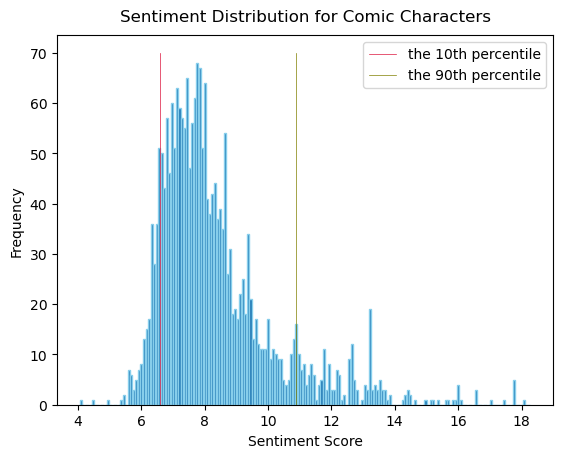

In [16]:
dist = dict(zip(list(df_all.CharacterName.values), list(df_all.Sentiment.values)))
v    = np.arange(min(df_all.Sentiment), max(df_all.Sentiment), step=0.08)

# plotting
plt.hist(dist.values(), v, ec = 'skyblue', rwidth=.8)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.plot([df_all.tenth,df_all.tenth], [0,70], c='crimson', lw=.5, label='the 10th percentile')
plt.plot([df_all.ninetieth,df_all.ninetieth], [0,70], c='olive',lw=.5, label='the 90th percentile')
plt.title('Sentiment Distribution for Comic Characters', pad=10.0)
plt.legend(['the 10th percentile','the 90th percentile'], loc='upper right')
plt.show()

In [21]:
goodbad = 'https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/b1668fe5fbea0765ed6f9cf896bfaf208a13765b/files/wiki_meta_data.csv'

df_goodbad = pd.read_csv(goodbad, sep=',', 
                usecols=['CharacterName','good','bad'],
                engine='python')
df_goodbad = df_goodbad.merge(df_all, how='left', on='CharacterName')

In [22]:
# having two different df for good and bad section
df_good, df_good.name = df_goodbad[df_goodbad.good==1], 'the comic heroes' 
df_bad, df_bad.name   = df_goodbad[df_goodbad.bad==1], 'the comic villains'

In [23]:
stats(df_good)
stats(df_bad)

Here are the sentiment stats of the comic heroes
The mean of the sentiment score is 9.193405079738115
The 10th percentile of the sentiment score is 7.052850490196078
The 90th percentile of the sentiment score is 12.173401296352603
Here are the sentiment stats of the comic villains
The mean of the sentiment score is 8.318378493921877
The 10th percentile of the sentiment score is 6.483875000000002
The 90th percentile of the sentiment score is 10.653917197452227


In [25]:
# plotting the distributions for both good and bad in the same plot
dist_g = dict(zip(list(df_good.CharacterName.values), list(df_good.Sentiment.values)))
v_g    = np.arange(min(df_good.Sentiment), max(df_good.Sentiment), step=0.08)
dist_b = dict(zip(list(df_bad.CharacterName.values), list(df_bad.Sentiment.values)))
v_b    = np.arange(min(df_bad.Sentiment), max(df_bad.Sentiment), step=0.08)

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.hist(dist_g.values(), v, ec = 'skyblue', rwidth=.8)
ax2.hist(dist_b.values(), v, ec = 'skyblue', rwidth=.8)
ax2.set_xlabel('Sentiment Score')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency')
ax1.plot([df_good.tenth,df_good.tenth], [0,20], c='crimson', lw=.5, 
            label='the 10th percentile')
ax1.plot([df_good.ninetieth,df_good.ninetieth], [0,20], c='olive',
            lw=.5, label='the 90th percentile')
ax2.plot([df_bad.tenth,df_bad.tenth], [0,20], c='crimson', lw=.5, 
            label='the 10th percentile')
ax2.plot([df_bad.ninetieth,df_bad.ninetieth], [0,20], c='olive',lw=.5, 
            label='the 90th percentile')
ax1.set_title('Sentiment Distribution for good/bad Comic Characters', pad=10.0)
ax1.legend(['the 10th percentile','the 90th percentile'], loc='upper right')
ax2.legend(['the 10th percentile','the 90th percentile'], loc='upper right')
plt.show()

From the stats above, we can conclude that the good guys are above average sentimental and the bad guys are the opposite, just as the locations of interval of the 10th and 90th percentile indicate. The interval from heroes starts at 7 whereas the villains' about 6.5, and the heroes’ lasts longer. Revisiting our hypotheses: 1) Good characters have a higher average value for sentiment than a similarly sized set of randomly selected characters; 2) Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters. It’s highly likely that both hypotheses are true as far as these data suggest.